In [27]:
import re
import string
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import word_tokenize

from sklearn.utils import shuffle
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"
import tqdm
import time

[nltk_data] Downloading package punkt to /home/k0nstant1n/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/k0nstant1n/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/k0nstant1n/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_json('agora_hack_products.json')
df.head()

,product_id,name,props,is_reference,reference_id
0,0007302f2fe1d54d,Классическая сплит-система ROYAL CLIMA PANDORA...,"[Класс энергоэффективности\tA, Мощность конд...",False,f497219eb0077f84
1,000740b6c1cc763e,Смартфон Xiaomi Redmi Note 10S NFC 6/128 ГБ RU...,"[Экран\t6.43"" (2400x1080) AMOLED 60 Гц, 4 каме...",True,None
2,0039af5efceac4ab,Холодильник Бирюса 118,[Мощность замораживания 4 кг/сутки],False,28085e941cde1639
3,004f2158acb8165c,ASUS TUF-GTX1660S-O6G-GAMING Видеокарта,"[Объем видеопамяти\t6144 МБ, Частота памяти\...",False,9afe55bb4bf1e8a8
4,005cddb29e1677ec,"Кофемашина Saeco Lirika One Touch Cappuccino, ...","[Приготовление капучино\tавтоматическое, Мате...",False,1f21918ceb5d345c


In [3]:
products_df = df[df.is_reference==False]
references_df = df[df.is_reference][['product_id', 'name', 'props']]

In [7]:
products_df.head()

,product_id,name,props,is_reference,reference_id
0,0007302f2fe1d54d,Классическая сплит-система ROYAL CLIMA PANDORA...,"[Класс энергоэффективности\tA, Мощность конд...",False,f497219eb0077f84
2,0039af5efceac4ab,Холодильник Бирюса 118,[Мощность замораживания 4 кг/сутки],False,28085e941cde1639
3,004f2158acb8165c,ASUS TUF-GTX1660S-O6G-GAMING Видеокарта,"[Объем видеопамяти\t6144 МБ, Частота памяти\...",False,9afe55bb4bf1e8a8
4,005cddb29e1677ec,"Кофемашина Saeco Lirika One Touch Cappuccino, ...","[Приготовление капучино\tавтоматическое, Мате...",False,1f21918ceb5d345c
6,0083dddef6bc6503,Lenovo 62A8KAT1EU Монитор,[Яркость\t250 кд/м²; контрастность: 1000:1],False,8f9c8fcf9cb2862c


In [8]:
references_df.head()

,product_id,name,props
1,000740b6c1cc763e,Смартфон Xiaomi Redmi Note 10S NFC 6/128 ГБ RU...,"[Экран\t6.43"" (2400x1080) AMOLED 60 Гц, 4 каме..."
5,0083737f904dd9a9,Фен LUMME LU-1058,"[Мощность\t1400 Вт, Насадки\tконцентратор, Вес..."
14,01378fa92f901df5,"15.6"" Ноутбук Lenovo IdeaPad 3 15ARE05 1920x10...","[Экран\t15.6"" (1920x1080) IPS, Процессор\tAMD..."
19,01601abb0bf5133d,"Микроволновая печь Hyundai HYM-D2071, серебристый","[Объем\t20 л, Переключатели\tкнопочные, Мощнос..."
22,01a28e17323d6ef8,Принтер лазерный Xerox Phaser 3020BI,"[Интерфейсы USB, Wi-Fi, AirPrint, Назначение\t..."


In [9]:
products_df[products_df.reference_id==references_df.product_id[1]]

,product_id,name,props,is_reference,reference_id
117,07d75a993b4cb8ef,XIAOMI Смартфон Xiaomi Redmi Note 10S 6/128GB ...,"[MediaTek Helio G95, Вес\t179 г, Экран\t6.43"" ...",False,000740b6c1cc763e
435,22f7a594ecd45010,"Смартфон Xiaomi Redmi Note 10S RU, 6.43"", Amol...","[Экран\t6.43"" (2400x1080) AMOLED 60 Гц, Беспр...",False,000740b6c1cc763e
1426,70237f55cce0a3f1,Смартфон Xiaomi Redmi Note 10S NFC 6/128 ГБ RU...,"[Оперативная память\t6 ГБ, Стандарт связи 2G, ...",False,000740b6c1cc763e
2320,b6d8970d9ddc12c1,Смартфон Xiaomi Redmi Note 10S 6GB+128GB White,"[Степень защиты\tIP53, Аккумулятор\t5000 мА·ч,...",False,000740b6c1cc763e
2414,bf467d89878d2168,Смартфон/акссесуар Xiaomi Redmi note 10S 6/128...,[MediaTek Helio G95],False,000740b6c1cc763e
2721,d54ed20dc222f6e0,Смартфон Xiaomi Redmi Note 10S 6+128GB White,"[Аккумулятор\t5000 мА·ч, Встроенная память\t12...",False,000740b6c1cc763e


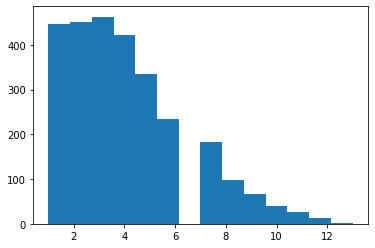

In [10]:
plt.hist([len(prop) for prop in products_df.props[products_df.index]], bins=14);

In [8]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/k0nstant1n/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [41]:
from sklearn.cluster import KMeans
class Clusterizer:
    def __init__(self, vectorized_data, verbose=0):
        self.data = vectorized_data
        self.cluster = KMeans()
        self.verbose = verbose
    
    def get_n_clusters(self):
        K = range(1,int(len(self.data)**0.5))
        if self.verbose==1:
            print('clustering...')
        models = [KMeans(n_clusters=k,random_state=42, n_init=3, verbose=self.verbose).fit(self.data) for k in K]
        if self.verbose==1:
            print('dist counting...')
        dist = [model.inertia_ for model in models]
        derivative_delta = [((dist[i]-dist[0])/(K[i]-K[0]))/((dist[-1]-dist[i])/(K[-1]-K[i])) for i in range(1, len(K)-1)]
        print(*enumerate(derivative_delta))
        
clusterizer=Clusterizer(X_tf_wob, verbose=1)
clusterizer.get_n_clusters()

clustering...
Initialization complete
Iteration 0, inertia 5510.866823456096.
Iteration 1, inertia 2718.2734785906887.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5384.503327884562.
Iteration 1, inertia 2718.2734785906882.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5390.865519283829.
Iteration 1, inertia 2718.2734785906887.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5352.530070504773
Iteration 1, inertia 2697.016122217947
Iteration 2, inertia 2687.8887266203487
Iteration 3, inertia 2684.2756244703446
Iteration 4, inertia 2683.4471017435126
Iteration 5, inertia 2682.8565076651093
Iteration 6, inertia 2682.3448510769913
Iteration 7, inertia 2682.3069283308914
Iteration 8, inertia 2682.29716510854
Iteration 9, inertia 2682.294263274457
Iteration 10, inertia 2682.292776752219
Converged at iteration 10: strict convergence.
Initialization complete
Ite

Iteration 0, inertia 4892.563022827674
Iteration 1, inertia 2573.854332677693
Iteration 2, inertia 2548.451478058352
Iteration 3, inertia 2530.5016295207047
Iteration 4, inertia 2526.8692542365616
Iteration 5, inertia 2526.7545568510213
Iteration 6, inertia 2526.7317417003424
Iteration 7, inertia 2526.722631831008
Iteration 8, inertia 2526.7194132799623
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 4898.7984065832525
Iteration 1, inertia 2567.067264293021
Iteration 2, inertia 2530.9697367702506
Iteration 3, inertia 2524.3775191919613
Iteration 4, inertia 2518.807967090056
Iteration 5, inertia 2518.1117729136704
Iteration 6, inertia 2517.3627268580785
Iteration 7, inertia 2514.9578447965973
Iteration 8, inertia 2511.7021956406447
Iteration 9, inertia 2511.2643952521903
Iteration 10, inertia 2510.7732117461937
Iteration 11, inertia 2509.966855672857
Iteration 12, inertia 2507.0584750125695
Iteration 13, inertia 2499.157400787718
Iteration 14, 

Iteration 13, inertia 2397.988689532485
Iteration 14, inertia 2397.6948772228334
Iteration 15, inertia 2397.6476068130874
Iteration 16, inertia 2397.6163007162877
Iteration 17, inertia 2397.5915049767736
Iteration 18, inertia 2397.5617300845665
Iteration 19, inertia 2397.5448627176243
Converged at iteration 19: strict convergence.
Initialization complete
Iteration 0, inertia 4602.487084424495
Iteration 1, inertia 2467.3475469179357
Iteration 2, inertia 2435.183254213673
Iteration 3, inertia 2424.871797603823
Iteration 4, inertia 2422.022547878589
Iteration 5, inertia 2419.7252504919506
Iteration 6, inertia 2415.7449813750195
Iteration 7, inertia 2415.6321562201006
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 4542.653410096311
Iteration 1, inertia 2452.5748501141697
Iteration 2, inertia 2414.8422143439197
Iteration 3, inertia 2398.955602047579
Iteration 4, inertia 2397.472524395203
Iteration 5, inertia 2397.1676441207433
Iteration 6, inertia

Iteration 7, inertia 2281.859127158094
Iteration 8, inertia 2281.7492328029944
Iteration 9, inertia 2281.368087971625
Iteration 10, inertia 2280.297090478831
Iteration 11, inertia 2278.6914297180956
Iteration 12, inertia 2278.4842382779807
Converged at iteration 12: strict convergence.
Initialization complete
Iteration 0, inertia 4232.694383079708
Iteration 1, inertia 2342.0851367582127
Iteration 2, inertia 2300.159349362664
Iteration 3, inertia 2277.9005199450344
Iteration 4, inertia 2271.35787174463
Iteration 5, inertia 2269.926461635532
Iteration 6, inertia 2269.5329952988695
Iteration 7, inertia 2269.4442280859885
Iteration 8, inertia 2269.4282146882742
Iteration 9, inertia 2269.416774381773
Iteration 10, inertia 2269.4033514491202
Iteration 11, inertia 2269.2787401323044
Iteration 12, inertia 2268.862216937765
Iteration 13, inertia 2268.2744617891303
Iteration 14, inertia 2268.055965988709
Iteration 15, inertia 2267.9327530500254
Iteration 16, inertia 2267.766953097079
Iteration 1

Initialization complete
Iteration 0, inertia 4078.2082577575775
Iteration 1, inertia 2213.7359767473927
Iteration 2, inertia 2183.4149533387954
Iteration 3, inertia 2167.7418008993486
Iteration 4, inertia 2158.944022892675
Iteration 5, inertia 2145.937580779429
Iteration 6, inertia 2143.9542262466252
Iteration 7, inertia 2143.8325079139204
Iteration 8, inertia 2143.7755488752236
Iteration 9, inertia 2143.733833667925
Iteration 10, inertia 2143.7170057545663
Iteration 11, inertia 2143.6993826470825
Iteration 12, inertia 2143.6904487740467
Iteration 13, inertia 2143.6815788101244
Converged at iteration 13: strict convergence.
Initialization complete
Iteration 0, inertia 4051.6575012726075
Iteration 1, inertia 2224.827682628393
Iteration 2, inertia 2186.666788178809
Iteration 3, inertia 2181.3865943803394
Iteration 4, inertia 2179.0649610843743
Iteration 5, inertia 2177.028465359861
Iteration 6, inertia 2176.1578286117956
Iteration 7, inertia 2174.7351811534827
Iteration 8, inertia 2172.6

Iteration 3, inertia 2112.532177969172
Iteration 4, inertia 2110.3669668768184
Iteration 5, inertia 2108.9906132860815
Iteration 6, inertia 2108.0081229516754
Iteration 7, inertia 2107.2380072875376
Iteration 8, inertia 2106.8358137665446
Iteration 9, inertia 2106.5799266999757
Iteration 10, inertia 2106.5348505816346
Iteration 11, inertia 2106.469448000394
Iteration 12, inertia 2106.455241467794
Converged at iteration 12: strict convergence.
Initialization complete
Iteration 0, inertia 3893.781016332239
Iteration 1, inertia 2137.4500514562187
Iteration 2, inertia 2106.3933253606374
Iteration 3, inertia 2096.1387260884094
Iteration 4, inertia 2094.5935862752435
Iteration 5, inertia 2093.5995275041087
Iteration 6, inertia 2092.9590215757717
Iteration 7, inertia 2092.762938675936
Iteration 8, inertia 2092.5163589244253
Iteration 9, inertia 2092.093768794241
Iteration 10, inertia 2091.9923991067944
Converged at iteration 10: strict convergence.
Initialization complete
Iteration 0, inertia

Iteration 15, inertia 2056.3994760979267
Iteration 16, inertia 2056.0056794166303
Iteration 17, inertia 2055.6003914006365
Iteration 18, inertia 2055.5219558759172
Iteration 19, inertia 2055.483309825298
Iteration 20, inertia 2055.472549015938
Converged at iteration 20: strict convergence.
Initialization complete
Iteration 0, inertia 3770.1873199639035
Iteration 1, inertia 2111.948965202566
Iteration 2, inertia 2089.0643389229426
Iteration 3, inertia 2080.949476720352
Iteration 4, inertia 2074.186384144599
Iteration 5, inertia 2067.5357058994587
Iteration 6, inertia 2061.2516237015093
Iteration 7, inertia 2058.9420105735417
Iteration 8, inertia 2058.345925101433
Iteration 9, inertia 2058.275798146262
Iteration 10, inertia 2058.2505800751737
Iteration 11, inertia 2058.2306501939806
Converged at iteration 11: strict convergence.
Initialization complete
Iteration 0, inertia 3761.73232719309
Iteration 1, inertia 2089.2165165019164
Iteration 2, inertia 2061.073779102114
Iteration 3, inertia

Iteration 8, inertia 2028.8794657530407
Iteration 9, inertia 2028.4291501251266
Iteration 10, inertia 2028.0911252041692
Iteration 11, inertia 2027.6132721328997
Iteration 12, inertia 2027.3371321935404
Iteration 13, inertia 2027.2031530361692
Iteration 14, inertia 2027.1732100586567
Iteration 15, inertia 2027.1247367068506
Iteration 16, inertia 2027.0719717991424
Iteration 17, inertia 2027.0575160290746
Converged at iteration 17: strict convergence.
Initialization complete
Iteration 0, inertia 3654.3140579967667
Iteration 1, inertia 2064.0134816609016
Iteration 2, inertia 2032.9185038008484
Iteration 3, inertia 2019.9757825179586
Iteration 4, inertia 2014.1800132813742
Iteration 5, inertia 2011.7535442298451
Iteration 6, inertia 2011.2853637139422
Iteration 7, inertia 2011.208214886724
Iteration 8, inertia 2011.1383243402647
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 3676.2850702088576
Iteration 1, inertia 2060.5799539957607
Iteration 2,

Iteration 7, inertia 1999.0999928008405
Iteration 8, inertia 1996.9655320880267
Iteration 9, inertia 1995.284488807075
Iteration 10, inertia 1994.791277188474
Iteration 11, inertia 1994.6527945792882
Iteration 12, inertia 1994.6295792605129
Converged at iteration 12: strict convergence.
Initialization complete
Iteration 0, inertia 3605.857738430613
Iteration 1, inertia 2040.2533713603245
Iteration 2, inertia 2013.2724662398664
Iteration 3, inertia 2004.6501856429925
Iteration 4, inertia 2000.959995846288
Iteration 5, inertia 1998.4116575065484
Iteration 6, inertia 1996.6405338014324
Iteration 7, inertia 1995.6823856750348
Iteration 8, inertia 1995.1715169543488
Iteration 9, inertia 1994.8135053793796
Iteration 10, inertia 1994.2606326748912
Iteration 11, inertia 1993.5998034486672
Iteration 12, inertia 1993.2636836866884
Iteration 13, inertia 1993.2492279166202
Converged at iteration 13: strict convergence.
Initialization complete
Iteration 0, inertia 3511.5209232699854
Iteration 1, in

Initialization complete
Iteration 0, inertia 3516.23332886658
Iteration 1, inertia 2002.034061852646
Iteration 2, inertia 1976.298728498343
Iteration 3, inertia 1966.7625485341166
Iteration 4, inertia 1962.4922686308555
Iteration 5, inertia 1959.5312513495262
Iteration 6, inertia 1957.3714943976365
Iteration 7, inertia 1956.80115672157
Iteration 8, inertia 1956.6421483790684
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 3538.6064301279735
Iteration 1, inertia 2027.82843411065
Iteration 2, inertia 1997.7313627365415
Iteration 3, inertia 1987.8604506381441
Iteration 4, inertia 1982.9489224007039
Iteration 5, inertia 1980.911513124242
Iteration 6, inertia 1979.813864501121
Iteration 7, inertia 1978.7912528278896
Iteration 8, inertia 1978.016003436486
Iteration 9, inertia 1977.3750937497111
Iteration 10, inertia 1976.6773904376755
Iteration 11, inertia 1975.9715641193272
Iteration 12, inertia 1975.4110399380481
Iteration 13, inertia 1975.0341940

Iteration 1, inertia 1985.0502776748829
Iteration 2, inertia 1957.3772145645298
Iteration 3, inertia 1947.3520002572222
Iteration 4, inertia 1943.3975472350303
Iteration 5, inertia 1940.4361120272233
Iteration 6, inertia 1938.5987120824343
Iteration 7, inertia 1938.1201031913229
Iteration 8, inertia 1937.589033148364
Iteration 9, inertia 1937.272813539079
Iteration 10, inertia 1936.61421113304
Iteration 11, inertia 1936.1506721135872
Iteration 12, inertia 1935.9942704806215
Iteration 13, inertia 1935.9270922774963
Iteration 14, inertia 1935.8786814158427
Iteration 15, inertia 1935.8248240047558
Iteration 16, inertia 1935.749112839934
Iteration 17, inertia 1935.6834381388014
Iteration 18, inertia 1935.5982804065898
Iteration 19, inertia 1935.537737815235
Iteration 20, inertia 1935.4997382033032
Iteration 21, inertia 1935.4819007164554
Iteration 22, inertia 1935.4578037927117
Iteration 23, inertia 1935.392863950685
Iteration 24, inertia 1935.335224255773
Iteration 25, inertia 1935.301973

Iteration 11, inertia 1938.5973341639724
Converged at iteration 11: strict convergence.
Initialization complete
Iteration 0, inertia 3424.584327588269
Iteration 1, inertia 1972.3680115898383
Iteration 2, inertia 1942.593751426178
Iteration 3, inertia 1932.9248379273695
Iteration 4, inertia 1929.0140871481121
Iteration 5, inertia 1925.8948499651642
Iteration 6, inertia 1923.9016303101193
Iteration 7, inertia 1923.4230214190077
Iteration 8, inertia 1922.8919513760488
Iteration 9, inertia 1922.5757317667635
Iteration 10, inertia 1921.9171293607249
Iteration 11, inertia 1921.453590341272
Iteration 12, inertia 1921.2971887083058
Iteration 13, inertia 1921.2300105051813
Iteration 14, inertia 1921.1815996435275
Iteration 15, inertia 1921.1277422324406
Iteration 16, inertia 1921.052031067619
Iteration 17, inertia 1920.9863563664865
Iteration 18, inertia 1920.9011986342744
Iteration 19, inertia 1920.8406560429198
Iteration 20, inertia 1920.8026564309885
Iteration 21, inertia 1920.7848189441402


In [4]:
class TextNormalyzer:
    def __init__(self):
        self.vectorizer = TfidfVectorizer()
        
    # some text cleaning functions
    def convert_to_lower(self, text):
        return text.lower()

    def remove_numbers(self, text):
        number_pattern = r'\d+'
        without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
        return without_number

    def lemmatizing(self, text):
        lemmatizer = WordNetLemmatizer()
        tokens = word_tokenize(text)
        return " ".join(list(map(lemmatizer.lemmatize, tokens)))

    def remove_punctuation(self, text):
        return text.translate(str.maketrans('', '', string.punctuation))

    def remove_stopwords(self, text):
        removed = []
        stop_words = list(stopwords.words("russian"))
        tokens = word_tokenize(text)
        for i in range(len(tokens)):
            if tokens[i] not in stop_words:
                removed.append(tokens[i])
        return " ".join(removed)

    def remove_extra_white_spaces(self, text):
        single_char_pattern = r'\s+[a-zA-Z]\s+'
        without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
        return without_sc
    
    def text_joining(self, df):
        return df['name']
    
    def text_clearing(self, dataframe):
        dataframe['text'] = [""]*len(dataframe)
        for i in dataframe.index:
            dataframe['text'][i] = dataframe['name'][i]+" "+" ".join(dataframe['props'][i])
        dataframe['text'] = dataframe['text'].str.lower()
        #products_df['name'] = products_df['name'].apply(lambda x: remove_numbers(x))
        dataframe['text'] = dataframe['text'].apply(lambda x: self.remove_punctuation(x))
        dataframe['text'] = dataframe['text'].apply(lambda x: self.remove_stopwords(x))
        dataframe['text'] = dataframe['text'].apply(lambda x: self.remove_extra_white_spaces(x))
        dataframe['text'] = dataframe['text'].apply(lambda x: self.lemmatizing(x))
        return dataframe['text']
    
    def all_df_to_vec(self, dataframe):
        X_tf_wob = self.vectorizer.fit_transform(self.text_clearing(dataframe))
        X_tf_wob = X_tf_wob.toarray()
        return X_tf_wob

In [12]:
products_df.head()

,product_id,name,props,is_reference,reference_id
0,0007302f2fe1d54d,Классическая сплит-система ROYAL CLIMA PANDORA...,"[Класс энергоэффективности\tA, Мощность конд...",False,f497219eb0077f84
2,0039af5efceac4ab,Холодильник Бирюса 118,[Мощность замораживания 4 кг/сутки],False,28085e941cde1639
3,004f2158acb8165c,ASUS TUF-GTX1660S-O6G-GAMING Видеокарта,"[Объем видеопамяти\t6144 МБ, Частота памяти\...",False,9afe55bb4bf1e8a8
4,005cddb29e1677ec,"Кофемашина Saeco Lirika One Touch Cappuccino, ...","[Приготовление капучино\tавтоматическое, Мате...",False,1f21918ceb5d345c
6,0083dddef6bc6503,Lenovo 62A8KAT1EU Монитор,[Яркость\t250 кд/м²; контрастность: 1000:1],False,8f9c8fcf9cb2862c


In [5]:
products_df['ref_id'] = [0]*len(products_df)
for i, ref_id in enumerate(references_df.product_id):
    products_df['ref_id'][products_df.reference_id==ref_id] = i

In [14]:
products_df.head()

,product_id,name,props,is_reference,reference_id,ref_id
0,0007302f2fe1d54d,Классическая сплит-система ROYAL CLIMA PANDORA...,"[Класс энергоэффективности\tA, Мощность конд...",False,f497219eb0077f84,450
2,0039af5efceac4ab,Холодильник Бирюса 118,[Мощность замораживания 4 кг/сутки],False,28085e941cde1639,71
3,004f2158acb8165c,ASUS TUF-GTX1660S-O6G-GAMING Видеокарта,"[Объем видеопамяти\t6144 МБ, Частота памяти\...",False,9afe55bb4bf1e8a8,293
4,005cddb29e1677ec,"Кофемашина Saeco Lirika One Touch Cappuccino, ...","[Приготовление капучино\tавтоматическое, Мате...",False,1f21918ceb5d345c,60
6,0083dddef6bc6503,Lenovo 62A8KAT1EU Монитор,[Яркость\t250 кд/м²; контрастность: 1000:1],False,8f9c8fcf9cb2862c,268


In [14]:
products_df.ref_id.value_counts

<bound method IndexOpsMixin.value_counts of 0       450
2        71
3       293
4        60
6       268
       ... 
3245    232
3247    389
3248     47
3249    301
3250    225
Name: ref_id, Length: 2780, dtype: int64>

In [6]:
normalyzer = TextNormalyzer()
X_tf_wob = normalyzer.df_to_vec(products_df)

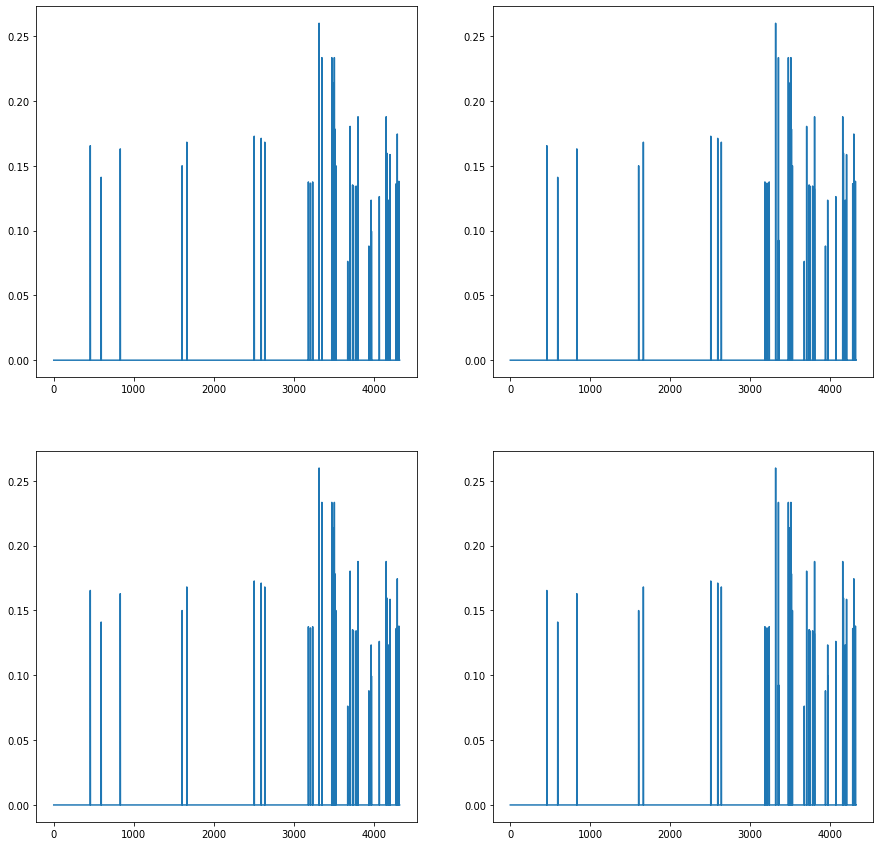

In [16]:
fig = plt.figure(figsize=(15,15))
ax = plt.subplot(221)
plt.plot(X_tf_wob[products_df[products_df.reference_id==references_df.product_id[1]].ref_id.values[products_df.index[0]]])
ax = plt.subplot(222)
plt.plot(X_tf_wob[products_df[products_df.reference_id==references_df.product_id[1]].ref_id.values[products_df.index[1]]])
ax = plt.subplot(223)
plt.plot(X_tf_wob[products_df[products_df.reference_id==references_df.product_id[1]].ref_id.values[products_df.index[2]]])
ax = plt.subplot(224)
plt.plot(X_tf_wob[products_df[products_df.reference_id==references_df.product_id[1]].ref_id.values[products_df.index[3]]])

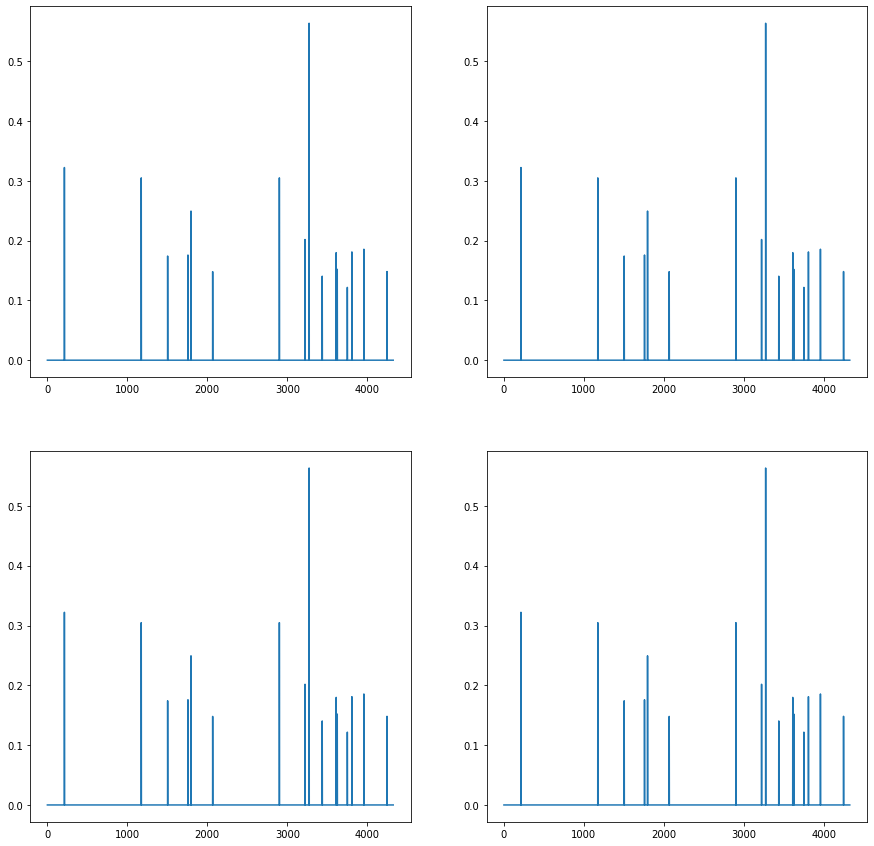

In [17]:
fig = plt.figure(figsize=(15,15))
prodid = 2
ax = plt.subplot(221)
plt.plot(X_tf_wob[products_df[products_df.reference_id==references_df.product_id[references_df.index[prodid]]].ref_id.values[products_df.index[0]]])
ax = plt.subplot(222)
plt.plot(X_tf_wob[products_df[products_df.reference_id==references_df.product_id[references_df.index[prodid]]].ref_id.values[products_df.index[1]]])
ax = plt.subplot(223)
plt.plot(X_tf_wob[products_df[products_df.reference_id==references_df.product_id[references_df.index[prodid]]].ref_id.values[products_df.index[2]]])
ax = plt.subplot(224)
plt.plot(X_tf_wob[products_df[products_df.reference_id==references_df.product_id[references_df.index[prodid]]].ref_id.values[products_df.index[3]]])

In [7]:
X_train_tf_wob, X_test_tf_wob, y_train_tf_wob, y_test_tf_wob = train_test_split(X_tf_wob, products_df['ref_id'].values, test_size=0.1)

# GausianNB

In [19]:
# initializing model
naiveBayes_wob = GaussianNB()

In [20]:
naiveBayes_wob.fit(X_train_tf_wob, y_train_tf_wob)

GaussianNB()

In [21]:
y_pred_tf_wob = naiveBayes_wob.predict(X_test_tf_wob)

In [22]:
print(accuracy_score(y_test_tf_wob, y_pred_tf_wob))

0.841726618705036


In [23]:
print(classification_report(y_test_tf_wob, y_pred_tf_wob))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         1
          17       1.00      1.00      1.00         1
          19       1.00      1.00      1.00         1
          21       1.00      0.50      0.67         2
          24       1.00      1.00      1.00         1
          25       0.00      0.00      0.00         1
          30       1.00      1.00      1.00         2
          31       1.00      1.00      1.00         1
          34       1.00      1.00      1.00         1
          35       1.00    

In [24]:
for i in range(len(X_tf_wob)-1):
    predict = naiveBayes_wob.predict(X_tf_wob[i:i+1])
    if predict[0]!=products_df.ref_id[products_df.index[i]]:
        print(predict[0], products_df.ref_id[products_df.index[i]])

144 324
280 131
25 206
366 390
178 258
425 462
277 57
25 206
40 125
434 371
123 369
308 303
0 358
25 206
416 153
45 251
308 303
454 355
443 220
443 220
425 462
350 129
325 159
204 376
386 384
357 163
398 214
112 163
319 468
204 83
462 425
386 384
25 206
206 25
317 321
25 206
327 371
181 267
357 163
141 255
380 128
327 256
91 307
360 114
352 164
25 206
157 152
36 422
220 21
440 348
321 358
308 303


In [25]:
naiveBayes_wob.predict(X_tf_wob[:100])

array([450,  71, 293,  60, 268, 451,  30, 397,  91,  65, 167, 381, 144,
       166, 390, 310, 150, 193, 196, 189, 119, 300, 268, 363, 398, 272,
       238,  18, 443, 177, 408, 346,  45, 162, 204, 402, 101,  16, 221,
       378, 337, 356, 336, 447, 221,  54, 384, 280, 305, 221, 277, 213,
       444, 356, 219, 205,  61,  55, 173,  17, 313, 298, 439, 246,  40,
       248, 227, 220, 113,  87, 403, 268,  27,   2, 148,  31, 129, 445,
        80, 392, 344,  59, 441, 417,  55,  52, 447,   8, 219,  34, 317,
       462, 422, 469,   8, 243, 301, 286, 134,  88])

100%|██████████| 150/150 [07:19<00:00,  2.93s/it]


(array([ 2.,  4.,  7., 19., 35., 33., 30., 11.,  7.,  2.]),
 array([0.78057554, 0.79316547, 0.8057554 , 0.81834532, 0.83093525,
        0.84352518, 0.85611511, 0.86870504, 0.88129496, 0.89388489,
        0.90647482]),
 <BarContainer object of 10 artists>)

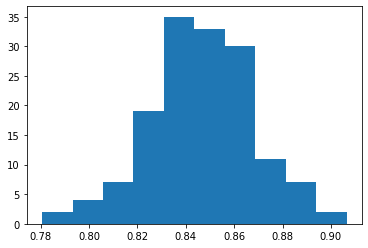

In [23]:
scores = []
for i in tqdm.tqdm(range(150)):
    X_train_tf_wob, X_test_tf_wob, y_train_tf_wob, y_test_tf_wob = train_test_split(X_tf_wob, products_df['ref_id'].values, test_size=0.2)
    naiveBayes_wob = GaussianNB()
    naiveBayes_wob.fit(X_train_tf_wob, y_train_tf_wob)
    y_pred_tf_wob = naiveBayes_wob.predict(X_test_tf_wob)
    scores.append(accuracy_score(y_test_tf_wob, y_pred_tf_wob))
plt.hist(scores, bins=10)

# CategoricalNB

In [8]:
from sklearn.naive_bayes import CategoricalNB

100%|██████████| 150/150 [1:31:40<00:00, 36.67s/it]


(array([ 4., 16.,  0., 24.,  0., 45., 24.,  0., 18., 19.]),
 array([0.        , 0.00215827, 0.00431655, 0.00647482, 0.00863309,
        0.01079137, 0.01294964, 0.01510791, 0.01726619, 0.01942446,
        0.02158273]),
 <BarContainer object of 10 artists>)

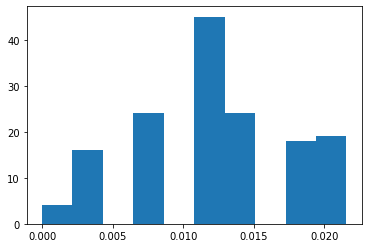

In [9]:
scores = []
for i in tqdm.tqdm(range(150)):
    X_train_tf_wob, X_test_tf_wob, y_train_tf_wob, y_test_tf_wob = train_test_split(X_tf_wob, products_df['ref_id'].values, test_size=0.2)
    naiveBayes_wob = CategoricalNB()
    naiveBayes_wob.fit(X_train_tf_wob, y_train_tf_wob)
    y_pred_tf_wob = naiveBayes_wob.predict(X_test_tf_wob)
    scores.append(accuracy_score(y_test_tf_wob, y_pred_tf_wob))
plt.hist(scores, bins=10)

# GBM

In [13]:
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm

In [14]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for num_leaves in [20, 31, 40]:
    for learning_rate in [0.1, 0.3]:
        for n_estimators in [100, 200, 300]:
            for min_child_samples in [2]:
                for reg_alpha in [0.0]:
                    for reg_lambda in [0.0]:
                        X_train_tf_wob, X_test_tf_wob, y_train_tf_wob, y_test_tf_wob = train_test_split(X_tf_wob, products_df['ref_id'].values)
                        lgbm = lightgbm.LGBMClassifier(boosting_type='gbdt',
                                                num_leaves=num_leaves,  #31,
                                                max_depth=-1,
                                                learning_rate=learning_rate,
                                                n_estimators=n_estimators,
                                                subsample_for_bin=200000,
                                                #objective='multiclass',
                                                #metric='multi_logloss',
                                                #num_classes=computed_params['nb_labels'],
                                                class_weight=None,
                                                min_split_gain=0.0,
                                                min_child_weight=0.001,
                                                min_child_samples=min_child_samples,
                                                subsample=1.0,
                                                subsample_freq=0,
                                                colsample_bytree=1.0,
                                                reg_alpha=reg_alpha,  #0.0,
                                                reg_lambda=reg_lambda,  #0.0,
                                                random_state=None,
                                                n_jobs=-1,
                                                silent=True,
                                                importance_type='split')
                        lgbm.fit(X_train_tf_wob, y_train_tf_wob)
                        y_pred_tf_wob = lgbm.predict(X_test_tf_wob)
                        print(num_leaves,learning_rate,n_estimators,min_child_samples,'|',accuracy_score(y_test_tf_wob, y_pred_tf_wob))

20 0.05 100 2 | 0.053237410071942444
20 0.05 100 10 | 0.05611510791366906
20 0.05 100 20 | 0.37985611510791367
20 0.05 200 2 | 0.03884892086330935
20 0.05 200 10 | 0.058992805755395686
20 0.05 200 20 | 0.39568345323741005
20 0.05 300 2 | 0.10071942446043165
20 0.05 300 10 | 0.011510791366906475
20 0.05 300 20 | 0.39136690647482014
20 0.1 100 2 | 0.014388489208633094
20 0.1 100 10 | 0.0057553956834532375
20 0.1 100 20 | 0.014388489208633094
20 0.1 200 2 | 0.02014388489208633
20 0.1 200 10 | 0.014388489208633094
20 0.1 200 20 | 0.004316546762589928
20 0.1 300 2 | 0.01870503597122302
20 0.1 300 10 | 0.06618705035971223
20 0.1 300 20 | 0.0028776978417266188
20 0.3 100 2 | 0.7453237410071942
20 0.3 100 10 | 0.008633093525179856
20 0.3 100 20 | 0.011510791366906475
20 0.3 200 2 | 0.7223021582733813
20 0.3 200 10 | 0.0
20 0.3 200 20 | 0.011510791366906475
20 0.3 300 2 | 0.7280575539568346
20 0.3 300 10 | 0.010071942446043165
20 0.3 300 20 | 0.007194244604316547
31 0.05 100 2 | 0.0057553956834

100%|██████████| 50/50 [25:10<00:00, 30.21s/it]


(array([1., 2., 3., 8., 8., 6., 8., 8., 5., 1.]),
 array([0.69604317, 0.70521583, 0.71438849, 0.72356115, 0.73273381,
        0.74190647, 0.75107914, 0.7602518 , 0.76942446, 0.77859712,
        0.78776978]),
 <BarContainer object of 10 artists>)

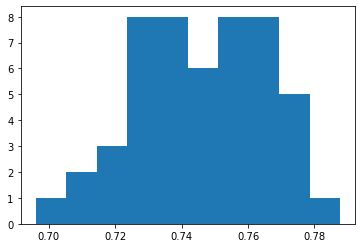

In [25]:
scores = []
for i in tqdm.tqdm(range(50)):
    X_train_tf_wob, X_test_tf_wob, y_train_tf_wob, y_test_tf_wob = train_test_split(X_tf_wob, products_df['ref_id'].values, test_size=0.2)
    lgbm = lightgbm.LGBMClassifier(boosting_type='gbdt',
                                                num_leaves=20,  #31,
                                                max_depth=-1,
                                                learning_rate=0.3,
                                                n_estimators=100,
                                                subsample_for_bin=200000,
                                                #objective='multiclass',
                                                #metric='multi_logloss',
                                                num_classes=len(references_df),
                                                class_weight='balanced',
                                                min_split_gain=0.0,
                                                min_child_weight=0.001,
                                                min_child_samples=2,
                                                subsample=1.0,
                                                subsample_freq=0,
                                                colsample_bytree=1.0,
                                                reg_alpha=reg_alpha,  #0.0,
                                                reg_lambda=reg_lambda,  #0.0,
                                                random_state=None,
                                                n_jobs=-1,
                                                silent=True,
                                                importance_type='split')
    lgbm.fit(X_train_tf_wob, y_train_tf_wob)
    y_pred_tf_wob = lgbm.predict(X_test_tf_wob)
    scores.append(accuracy_score(y_test_tf_wob, y_pred_tf_wob))
plt.hist(scores)

# Random Forest


In [28]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
rfc = RandomForestClassifier(n_estimators=1000) 

In [30]:
rfc.fit(X_train_tf_wob, y_train_tf_wob)

RandomForestClassifier(n_estimators=1000)

In [31]:
y_pred_tf_wob = rfc.predict(X_test_tf_wob)

In [32]:
print(accuracy_score(y_test_tf_wob, y_pred_tf_wob))

0.8453237410071942


100%|██████████| 20/20 [50:20<00:00, 151.01s/it]


(array([3., 1., 1., 3., 1., 0., 1., 7., 2., 1.]),
 array([0.80215827, 0.80971223, 0.81726619, 0.82482014, 0.8323741 ,
        0.83992806, 0.84748201, 0.85503597, 0.86258993, 0.87014388,
        0.87769784]),
 <BarContainer object of 10 artists>)

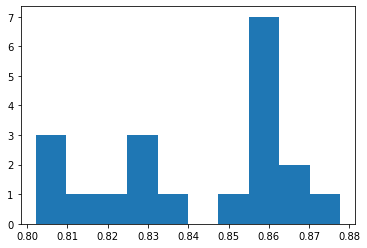

In [44]:
scores = []
for i in tqdm.tqdm(range(20)):
    X_train_tf_wob, X_test_tf_wob, y_train_tf_wob, y_test_tf_wob = train_test_split(X_tf_wob, products_df['ref_id'].values, test_size=0.2)
    rfc = RandomForestClassifier(n_estimators=500)
    rfc.fit(X_train_tf_wob, y_train_tf_wob)
    y_pred_tf_wob = rfc.predict(X_test_tf_wob)
    scores.append(accuracy_score(y_test_tf_wob, y_pred_tf_wob))
plt.hist(scores, bins=10)

In [33]:
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [34]:
precision_score(y_test_tf_wob, y_pred_tf_wob, average='macro')

0.7481398809523808

In [35]:
recall_score(y_test_tf_wob, y_pred_tf_wob, average='macro')

0.7566964285714286

In [36]:
f1_score(y_test_tf_wob, y_pred_tf_wob, average='macro')

0.7429634353741496

# clusterisation

In [37]:
len(references_df)

471

In [38]:
from sklearn.cluster import KMeans

In [39]:
K = range(400, 500)
models = [KMeans(n_clusters=k, random_state=42, verbose=1, n_init=3).fit(X_tf_wob) for k in K]
dist = [model.inertia_ for model in models]

Initialization complete
Iteration 0, inertia 1976.663475428795
Iteration 1, inertia 1233.6051633921709
Iteration 2, inertia 1217.9519237128104
Iteration 3, inertia 1213.7684758924065
Iteration 4, inertia 1212.872622986646
Iteration 5, inertia 1212.5730971529363
Iteration 6, inertia 1212.4697635630819
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 1972.5613008772832
Iteration 1, inertia 1237.5520091946157
Iteration 2, inertia 1222.0767898598149
Iteration 3, inertia 1218.2491423964348
Iteration 4, inertia 1217.423948476714
Iteration 5, inertia 1216.9823129109159
Iteration 6, inertia 1216.8293447695373
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 1971.291536269585
Iteration 1, inertia 1233.0165780015575
Iteration 2, inertia 1217.6308062783594
Iteration 3, inertia 1212.9823876344185
Iteration 4, inertia 1210.9230020985751
Iteration 5, inertia 1210.517891711336
Converged at iteration 5: strict converge

KeyboardInterrupt: 

In [ ]:
plt.plot(K, dist, marker='o')

# KNC

In [46]:
from sklearn.neighbors import KNeighborsClassifier

## algorithm: auto

100%|██████████| 150/150 [00:33<00:00,  4.51it/s]


(array([ 2.,  2.,  9., 18., 40., 42., 19., 10.,  5.,  3.]),
 array([0.60611511, 0.61798561, 0.62985612, 0.64172662, 0.65359712,
        0.66546763, 0.67733813, 0.68920863, 0.70107914, 0.71294964,
        0.72482014]),
 <BarContainer object of 10 artists>)

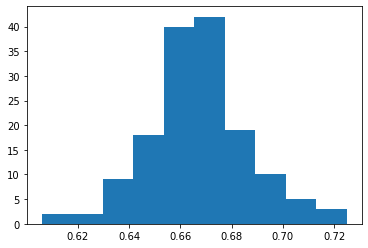

In [55]:
scores = []
for i in tqdm.tqdm(range(150)):
    X_train_tf_wob, X_test_tf_wob, y_train_tf_wob, y_test_tf_wob = train_test_split(X_tf_wob, products_df['ref_id'].values, test_size=0.2)
    knc = KNeighborsClassifier()
    knc.fit(X_train_tf_wob, y_train_tf_wob)
    y_pred_tf_wob = knc.predict(X_test_tf_wob)
    scores.append(accuracy_score(y_test_tf_wob, y_pred_tf_wob))
plt.hist(scores)

## algorithm: ball tree

100%|██████████| 150/150 [15:39<00:00,  6.26s/it]


(array([ 4.,  5., 12., 20., 24., 26., 28., 17., 10.,  4.]),
 array([0.61330935, 0.62338129, 0.63345324, 0.64352518, 0.65359712,
        0.66366906, 0.67374101, 0.68381295, 0.69388489, 0.70395683,
        0.71402878]),
 <BarContainer object of 10 artists>)

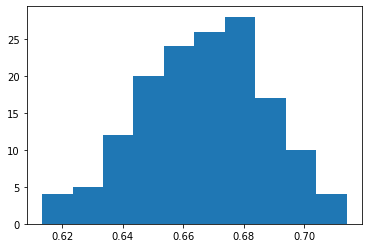

In [56]:
scores = []
for i in tqdm.tqdm(range(150)):
    X_train_tf_wob, X_test_tf_wob, y_train_tf_wob, y_test_tf_wob = train_test_split(X_tf_wob, products_df['ref_id'].values, test_size=0.2)
    knc = KNeighborsClassifier(algorithm='ball_tree')
    knc.fit(X_train_tf_wob, y_train_tf_wob)
    y_pred_tf_wob = knc.predict(X_test_tf_wob)
    scores.append(accuracy_score(y_test_tf_wob, y_pred_tf_wob))
plt.hist(scores)

## algoritm: kd tree

100%|██████████| 150/150 [19:40<00:00,  7.87s/it]


(array([ 6.,  6., 17., 15., 24., 23., 23., 19., 12.,  5.]),
 array([0.61510791, 0.625     , 0.63489209, 0.64478417, 0.65467626,
        0.66456835, 0.67446043, 0.68435252, 0.6942446 , 0.70413669,
        0.71402878]),
 <BarContainer object of 10 artists>)

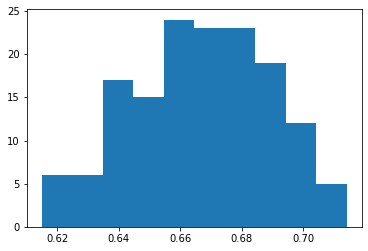

In [58]:
scores = []
for i in tqdm.tqdm(range(150)):
    X_train_tf_wob, X_test_tf_wob, y_train_tf_wob, y_test_tf_wob = train_test_split(X_tf_wob, products_df['ref_id'].values, test_size=0.2)
    knc = KNeighborsClassifier(algorithm='kd_tree')
    knc.fit(X_train_tf_wob, y_train_tf_wob)
    y_pred_tf_wob = knc.predict(X_test_tf_wob)
    scores.append(accuracy_score(y_test_tf_wob, y_pred_tf_wob))
plt.hist(scores)

## algoritm: brute

100%|██████████| 150/150 [00:54<00:00,  2.77it/s]


(array([ 2.,  2.,  4., 14., 22., 30., 41., 16., 15.,  4.]),
 array([0.59352518, 0.6057554 , 0.61798561, 0.63021583, 0.64244604,
        0.65467626, 0.66690647, 0.67913669, 0.69136691, 0.70359712,
        0.71582734]),
 <BarContainer object of 10 artists>)

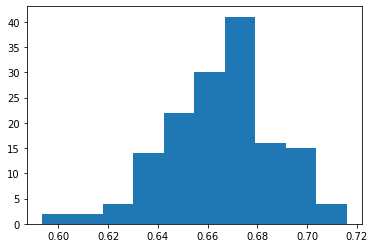

In [59]:
scores = []
for i in tqdm.tqdm(range(150)):
    X_train_tf_wob, X_test_tf_wob, y_train_tf_wob, y_test_tf_wob = train_test_split(X_tf_wob, products_df['ref_id'].values, test_size=0.2)
    knc = KNeighborsClassifier(algorithm='brute')
    knc.fit(X_train_tf_wob, y_train_tf_wob)
    y_pred_tf_wob = knc.predict(X_test_tf_wob)
    scores.append(accuracy_score(y_test_tf_wob, y_pred_tf_wob))
plt.hist(scores)

# Linear Discriminant Analysis

In [60]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [61]:
scores = []
for i in tqdm.tqdm(range(150)):
    X_train_tf_wob, X_test_tf_wob, y_train_tf_wob, y_test_tf_wob = train_test_split(X_tf_wob, products_df['ref_id'].values, test_size=0.2)
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train_tf_wob, y_train_tf_wob)
    y_pred_tf_wob = lda.predict(X_test_tf_wob)
    scores.append(accuracy_score(y_test_tf_wob, y_pred_tf_wob))
plt.hist(scores)

 25%|██▌       | 38/150 [26:05<1:16:55, 41.21s/it]


KeyboardInterrupt: 

# Метод опорных векторов

In [1]:
from sklearn.svm import SVC

100%|██████████| 150/150 [38:47<00:00, 15.51s/it]


(array([ 5., 10., 17., 13., 18., 25., 23., 16., 16.,  7.]),
 array([0.57014388, 0.57877698, 0.58741007, 0.59604317, 0.60467626,
        0.61330935, 0.62194245, 0.63057554, 0.63920863, 0.64784173,
        0.65647482]),
 <BarContainer object of 10 artists>)

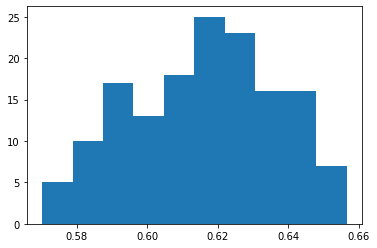

In [25]:
scores = []
for i in tqdm.tqdm(range(150)):
    X_train_tf_wob, X_test_tf_wob, y_train_tf_wob, y_test_tf_wob = train_test_split(X_tf_wob, products_df['ref_id'].values, test_size=0.2)
    svc = SVC()
    svc.fit(X_train_tf_wob, y_train_tf_wob)
    y_pred_tf_wob = svc.predict(X_test_tf_wob)
    scores.append(accuracy_score(y_test_tf_wob, y_pred_tf_wob))
plt.hist(scores)

# BAGGING

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import lightgbm
from sklearn.naive_bayes import GaussianNB

scores = []
for i in tqdm.tqdm(range(20)):
    X_train_tf_wob, X_test_tf_wob, y_train_tf_wob, y_test_tf_wob = train_test_split(X_tf_wob, products_df['ref_id'].values, test_size=0.2)
    rfc = RandomForestClassifier(n_estimators=500)
'''    lgbm = lightgbm.LGBMClassifier(boosting_type='gbdt',
                                                num_leaves=20,  #31,
                                                max_depth=-1,
                                                learning_rate=0.3,
                                                n_estimators=100,
                                                subsample_for_bin=200000,
                                                #objective='multiclass',
                                                #metric='multi_logloss',
                                                num_classes=len(references_df),
                                                class_weight='balanced',
                                                min_split_gain=0.0,
                                                min_child_weight=0.001,
                                                min_child_samples=2,
                                                subsample=1.0,
                                                subsample_freq=0,
                                                colsample_bytree=1.0,
                                                reg_alpha=reg_alpha,  #0.0,
                                                reg_lambda=reg_lambda,  #0.0,
                                                random_state=None,
                                                n_jobs=-1,
                                                silent=True,
                                                importance_type='split')
    '''
    naiveBayes_wob = GaussianNB()
    rfc.fit(X_train_tf_wob, y_train_tf_wob)
    #lgbm.fit(X_train_tf_wob, y_train_tf_wob)
    naiveBayes_wob.fit(X_train_tf_wob, y_train_tf_wob)
    print('start predict')
    start = time.time()
    for i in range(100):
        y_pred_tf_rfc = rfc.predict(X_test_tf_wob)
        #y_pred_tf_lgbm = lgbm.predict(X_test_tf_wob)
        y_pred_tf_wob = naiveBayes_wob.predict(X_test_tf_wob)
    deltatime = time.time()-start
    print(deltatime)
    print(np.concatenate(y_pred_tf_rfc.reshape(y_pred_tf_rfc.size),y_pred_tf_lgbm.reshape(y_pred_tf_lgbm.size),y_pred_tf_wob.reshape(y_pred_tf_wob.size), axis=1).transpose())